<a href="https://colab.research.google.com/github/s-choung/Simulation_tutorials/blob/main/handson10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install tqdm

In [2]:
!apt-get update
!sudo apt-get install povray
!pip install -q --upgrade pip
!pip install -q 'numpy>=1.25.0,<2.0.0'
!pip install -q mace-torch
!pip install -q mp_api
!pip install -q chgnet
!pip install -q pymatgen ase

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,172 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,449 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,487 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu

In [3]:
import shutil
from ase.io import write  # Import the write function from ASE
from PIL import Image
from IPython.display import display  # Import display for Jupyter Notebooks
import os

def visual(structure, repeat = (1,1,1), rotation='-75x, -17y, -4z', png_save_path='./'):
    structure = structure.repeat(repeat)
    renderer = write('./temp.pov', structure, rotation=rotation)
    renderer.render()
    image_path = './temp.png'
    img = Image.open(image_path)
    display(img)

    files = ['./temp.ini', './temp.pov', './temp.png']
    destination = './output/'

    os.makedirs(destination, exist_ok=True)

    for file in files:
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        if file == './temp.png':
            new_file_name = png_save_path + f'temp.png'
        else:
            new_file_name = os.path.basename(file)
        shutil.move(file, os.path.join(destination, new_file_name))

#Benchmarking MLPs by using Catalysis-hub data

https://www.catalysis-hub.org/publications

In [4]:
GRAPHQL = 'http://api.catalysis-hub.org/graphql'

In [5]:
import requests
import json
import copy
import io

def fetch(query):
    return requests.get(
        GRAPHQL, {'query': query}
    ).json()['data']


def reactions_from_dataset(pub_id, page_size=40):
    reactions = []
    has_next_page = True
    start_cursor = ''
    page = 0
    while has_next_page:
        data = fetch("""{{
      reactions(pubId: "{pub_id}", first: {page_size}, after: "{start_cursor}") {{
        totalCount
        pageInfo {{
          hasNextPage
          hasPreviousPage
          startCursor
          endCursor
        }}
        edges {{
          node {{
            Equation
            reactants
            products
            reactionEnergy
            reactionSystems {{
              name
              systems {{
                energy
                InputFile(format: "json")
              }}
            }}
          }}
        }}
      }}
    }}""".format(start_cursor=start_cursor,
                 page_size=page_size,
                 pub_id=pub_id,
                 ))
        has_next_page = data['reactions']['pageInfo']['hasNextPage']
        start_cursor = data['reactions']['pageInfo']['endCursor']
        page += 1
        print(has_next_page, start_cursor, page_size *
              page, data['reactions']['totalCount'])
        reactions.extend(map(lambda x: x['node'], data['reactions']['edges']))

    return reactions

def data2json(raw_reactions, dataset_name):
    raw_reactions_json = {"raw_reactions": raw_reactions}
    filename = f"{dataset_name}.json"
    path = os.path.join(os.getcwd(), filename)

    with open(path, 'w') as file:
        json.dump(raw_reactions_json, file, indent=4)

def aseify_reactions(reactions):
    for i, reaction in enumerate(reactions):
        for j, _ in enumerate(reactions[i]['reactionSystems']):
            system_info = reactions[i]['reactionSystems'][j].pop('systems')

            with io.StringIO() as tmp_file:
                tmp_file.write(system_info.pop('InputFile'))
                tmp_file.seek(0)
                atoms = read(tmp_file, format='json')
                atoms.pbc = True
                reactions[i]['reactionSystems'][j]['atoms'] = atoms

            reactions[i]['reactionSystems'][j]['energy'] = system_info['energy']

        reactions[i]['reactionSystems'] = {
            x['name']: {'atoms': x['atoms'], 'energy': x['energy']}
            for x in reactions[i]['reactionSystems']
        }

In [6]:
benchmark = 'ComerUnraveling2022'

if not os.path.exists(f'{benchmark}.json'):
    raw_reactions = reactions_from_dataset(benchmark)
    data2json(raw_reactions, benchmark)

with open(f'{benchmark}.json', 'r') as f:
    data = json.load(f)

True YXJyYXljb25uZWN0aW9uOjM5 40 132
True YXJyYXljb25uZWN0aW9uOjc5 80 132
True YXJyYXljb25uZWN0aW9uOjExOQ== 120 132
False YXJyYXljb25uZWN0aW9uOjEzMQ== 160 132


In [7]:
print(json.dumps(data, indent=4, ensure_ascii=False))

{
    "raw_reactions": [
        {
            "Equation": "H2O(g) - H2(g) + * -> O*",
            "reactants": "{\"star\": 1, \"H2gas\": -1.0, \"H2Ogas\": 1}",
            "products": "{\"Ostar\": 1}",
            "reactionEnergy": 4.7115982999999915,
            "reactionSystems": [
                {
                    "name": "Ostar",
                    "systems": {
                        "energy": -152.48072284,
                        "InputFile": "{\"1\": {\n \"cell\": {\"array\": {\"__ndarray__\": [[3, 3], \"float64\", [2.898755524, 0.0, 0.0, 0.0, 6.541740799, 0.0, 0.0, 0.0, 28.083481597]]}, \"__ase_objtype__\": \"cell\"},\n \"ctime\": 24.889845147737322,\n \"mtime\": 24.889845147737322,\n \"numbers\": {\"__ndarray__\": [[25], \"int64\", [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 26, 26, 26, 26, 26, 26, 26, 26]]},\n \"pbc\": {\"__ndarray__\": [[3], \"bool\", [true, true, true]]},\n \"positions\": {\"__ndarray__\": [[25, 3], \"float64\", [0.0, 0.0, 7.500000000000016, 

In [8]:
from ase.io import read

loaded_data = data['raw_reactions']
dat = copy.deepcopy(loaded_data)
aseify_reactions(dat)

In [9]:
dat

[{'Equation': 'H2O(g) - H2(g) + * -> O*',
  'reactants': '{"star": 1, "H2gas": -1.0, "H2Ogas": 1}',
  'products': '{"Ostar": 1}',
  'reactionEnergy': 4.7115982999999915,
  'reactionSystems': {'Ostar': {'atoms': Atoms(symbols='O17Fe8', pbc=True, cell=[2.898755524, 6.541740799, 28.083481597]),
    'energy': -152.48072284},
   'H2Ogas': {'atoms': Atoms(symbols='H2O', pbc=True, cell=[14.0, 16.526478, 16.596309]),
    'energy': -14.23091949},
   'star': {'atoms': Atoms(symbols='O16Fe8', pbc=True, cell=[2.898755524, 6.541740799, 28.083481597]),
    'energy': -149.73289355},
   'H2gas': {'atoms': Atoms(symbols='H2', pbc=True, cell=[14.0, 15.0, 16.737166]),
    'energy': -6.7714919},
   'bulkrutile': {'atoms': Atoms(symbols='Fe2O4', pbc=True, cell=[[4.6257092794390005, -1.0149280221e-06, 0.0], [-1.0149280221e-06, 4.6257092794390005, 0.0], [0.0, 0.0, 2.89875552352124]]),
    'energy': -37.71255722}}},
 {'Equation': 'H2O(g) - 0.5H2(g) + * -> HO*',
  'reactants': '{"star": 1, "H2gas": -0.5, "H2Og

Atoms(symbols='O16Fe8', pbc=True, cell=[2.898755524, 6.541740799, 28.083481597])


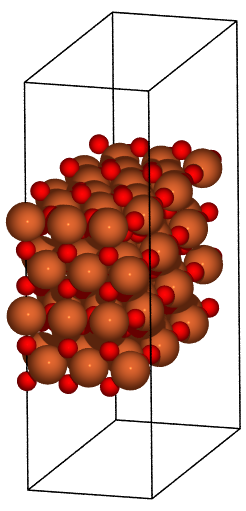

Atoms(symbols='O17Fe8', pbc=True, cell=[2.898755524, 6.541740799, 28.083481597])


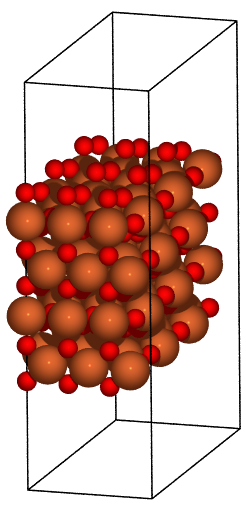

In [15]:
i = 0
print(dat[i]['reactionSystems']['star']['atoms'])
visual(dat[i]['reactionSystems']['star']['atoms'], (3,3,1))
print(dat[i]['reactionSystems']['Ostar']['atoms'])
visual(dat[i]['reactionSystems']['Ostar']['atoms'], (3,3,1))

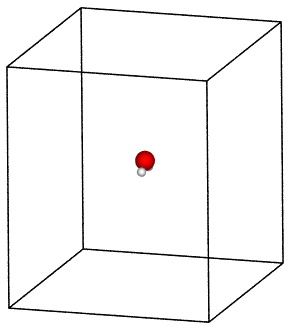

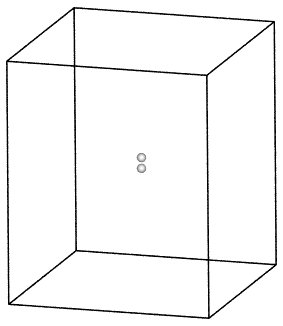

In [11]:
H2O_gas = dat[0]['reactionSystems']['H2Ogas']['atoms']
H2_gas = dat[0]['reactionSystems']['H2gas']['atoms']

visual(H2O_gas)
visual(H2_gas)

Atoms(symbols='O12V6', pbc=True, cell=[2.894390328, 4.598517887, 28.795548828])


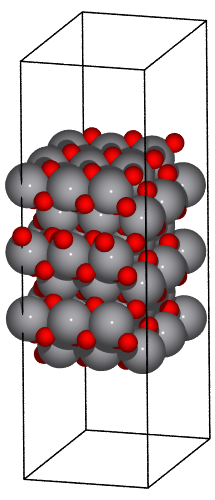

Atoms(symbols='O13V6', pbc=True, cell=[2.894390328, 4.598517887, 28.795548828])


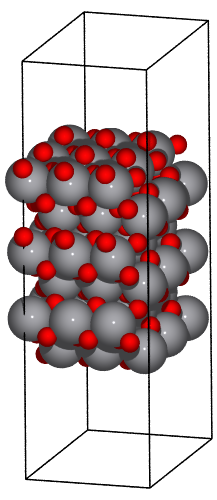

In [19]:
i = 10
print(dat[i]['reactionSystems']['star']['atoms'])
visual(dat[i]['reactionSystems']['star']['atoms'], (3,3,1))
print(dat[i]['reactionSystems']['Ostar']['atoms'])
visual(dat[i]['reactionSystems']['Ostar']['atoms'], (3,3,1))

In [22]:
print("length of database:",len(dat))
for data in dat:
  print(data['reactionSystems']['star']['atoms'])

length of database: 132
Atoms(symbols='O16Fe8', pbc=True, cell=[2.898755524, 6.541740799, 28.083481597])
Atoms(symbols='O16Fe8', pbc=True, cell=[2.898755524, 6.541740799, 28.083481597])
Atoms(symbols='O12Fe6', pbc=True, cell=[2.898755524, 4.625709279, 28.877127838])
Atoms(symbols='O12Fe6', pbc=True, cell=[2.898755524, 4.625709279, 28.877127838])
Atoms(symbols='O16Mn8', pbc=True, cell=[2.937524892, 6.31353593, 27.627071859])
Atoms(symbols='O16Mn8', pbc=True, cell=[2.937524892, 6.31353593, 27.627071859])
Atoms(symbols='O12Mn6', pbc=True, cell=[2.937524892, 4.464344069, 28.393032207])
Atoms(symbols='O12Mn6', pbc=True, cell=[2.937524892, 4.464344069, 28.393032207])
Atoms(symbols='O16V8', pbc=True, cell=[2.894390328, 6.506007454, 28.001128263])
Atoms(symbols='O16V8', pbc=True, cell=[2.894390328, 6.506007454, 28.001128263])
Atoms(symbols='O12V6', pbc=True, cell=[2.894390328, 4.598517887, 28.795548828])
Atoms(symbols='O12V6', pbc=True, cell=[2.894390328, 4.598517887, 28.795548828])
Atoms(symb

In [12]:
from copy import deepcopy
from ase.optimize import LBFGS

def energy_cal(calculator, atoms_origin):
    atoms = deepcopy(atoms_origin)
    atoms.calc =calculator
    tags = np.ones(len(atoms))
    atoms.set_tags(tags)

    opt = LBFGS(atoms)
    opt.run(fmax=0.03,steps = 100)

    return atoms.get_potential_energy(), atoms

In [23]:
from mace.calculators import mace_mp
import numpy as np

mace_calc = mace_mp(model="medium", dispersion=False, default_dtype="float64", device='cuda')

H2O_energy, _ = energy_cal(mace_calc, H2O_gas)
H2_energy, _ = energy_cal(mace_calc, H2_gas)

ads_energy_OH_MLP = []
ads_energy_O_MLP = []

ads_energy_OH_DFT = []
ads_energy_O_DFT = []

for i, _ in enumerate(dat):#[:10]
    print(f'-----------------{i+1}/{len(dat)}-----------------')
    if 'HOstar' in dat[i]['reactionSystems']:
        adslab = dat[i]['reactionSystems']['HOstar']['atoms']
        adosrbate = 'OH'
    elif 'Ostar' in dat[i]['reactionSystems']:
        adslab = dat[i]['reactionSystems']['Ostar']['atoms']
        adosrbate = 'O'
    else:
      print("Error")

    slab = dat[i]['reactionSystems']['star']['atoms']
    energy_slab, slab_calc = energy_cal(mace_calc, slab)

    energy_adslab, adslab_calc = energy_cal(mace_calc, adslab)

    if adosrbate == 'OH':
       ##### Exercise 1: Write appropriate adsorption energy equation
       adsorption_energy =  #### use energy_adslab, energy_slab, H2O_energy , H2_energy
       ads_energy_OH_MLP.append(adsorption_energy)
       ads_energy_OH_DFT.append(dat[i]['reactionEnergy'])

    elif adosrbate == 'O':
       ##### Exercise 4: Write appropriate adsorption energy equation
       adsorption_energy = #### use energy_adslab, energy_slab, H2O_energy , H2_energy
       ads_energy_O_MLP.append(adsorption_energy)
       ads_energy_O_DFT.append(dat[i]['reactionEnergy'])

/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

Cached MACE model to /root/.cache/mace/20231203mace128L1_epoch199model
Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


       Step     Time          Energy          fmax
LBFGS:    0 23:32:16      -14.160030        0.126395
LBFGS:    1 23:32:16      -14.160205        0.038245
LBFGS:    2 23:32:18      -14.160242        0.028770
       Step     Time          Energy          fmax
LBFGS:    0 23:32:18       -6.524347        0.101087
LBFGS:    1 23:32:20       -6.524490        0.002829
-----------------1/132-----------------
       Step     Time          Energy          fmax
LBFGS:    0 23:32:20     -146.606225        1.376384
LBFGS:    1 23:32:22     -146.673865        1.199366
LBFGS:    2 23:32:22     -146.866195        0.507385
LBFGS:    3 23:32:22     -146.878882        0.406513
LBFGS:    4 23:32:22     -146.918757        0.214791
LBFGS:    5 23:32:23     -146.922324        0.255646
LBFGS:    6 23:32:23     -146.934887        0.274469
LBFGS:    7 23:32:23     -146.941098        0.182801
LBFGS:    8 23:32:23     -146.945031        0.147839
LBFGS:    9 23:32:23     -146.947702        0.161601
LBFGS:   10 

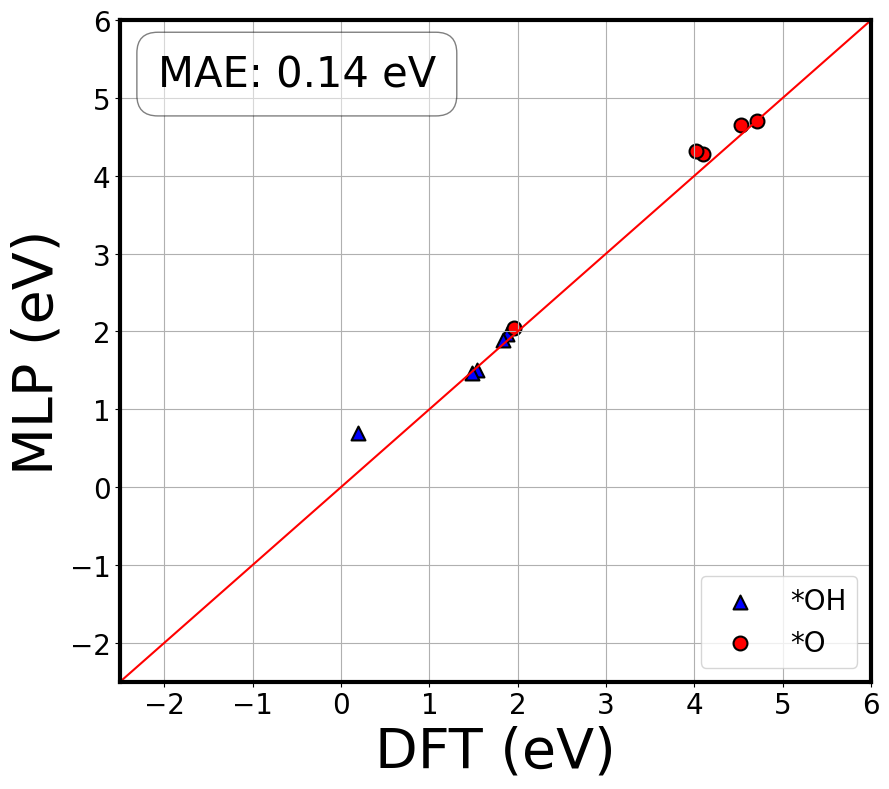

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 8))

mark_size = 100

ads_energy_OH_DFT = np.array(ads_energy_OH_DFT)
ads_energy_OH_MLP = np.array(ads_energy_OH_MLP)
ads_energy_O_DFT = np.array(ads_energy_O_DFT)
ads_energy_O_MLP = np.array(ads_energy_O_MLP)

##### Exercise 5: Scatter parity plot for OH adsorption energy
plt.scatter(###, ###, label='*OH', color ='blue', marker='^', s=mark_size, edgecolors='black', linewidths=1.5)

##### Exercise 6: Scatter parity plot for O adsorption energy
plt.scatter(###, ###, label='*O', color = 'red', marker='o', s=mark_size, edgecolors='black', linewidths=1.5)
texts = []

xl = -2.5
yl = 6

plt.xlim(xl,yl)
plt.ylim(xl,yl)
plt.plot([xl, yl], [xl, yl], 'r-')

MAE = (np.mean(np.abs(ads_energy_OH_DFT - ads_energy_OH_MLP)) + np.mean(np.abs(ads_energy_O_DFT - ads_energy_O_MLP))) / 2

plt.text(x=0.05, y=0.95,
         s=f'MAE: {MAE:.2f} eV',
         transform=plt.gca().transAxes, fontsize = 30,
         verticalalignment='top',
         bbox=dict(boxstyle="round", alpha=0.5, facecolor="white", edgecolor="black", pad=0.5))


plt.xlabel('DFT (eV)', fontsize = 40)
plt.ylabel('MLP (eV)', fontsize = 40)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc = 'lower right', fontsize = 20)
plt.grid(True)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(3)

plt.tight_layout()

# CatBench

In [26]:
!pip install catbench==0.1.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 130.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


In [ ]:
import catbench
benchmark = 'ComerUnraveling2022'

catbench.json2pkl(benchmark)

calculators = [mace_calc]

config = {
    "NNP_name": 'mace_catbench_test',
    "benchmark": benchmark,
    "rate": 0,
    "gas_distance": 30,
    "N_CRIT_RELAX": 100
}

catbench.execute_benchmark(calculators, **config)

Starting mace_catbench_test Benchmarking
Starting calculations...
[1/132] Fe8O16_H2O(g) - H2(g) + * -> O*
H2Ogas_0th calculating
H2gas_0th calculating
[2/132] Fe8O16_H2O(g) - 0.5H2(g) + * -> HO*
[3/132] Fe6O12_H2O(g) - H2(g) + * -> O*
[4/132] Fe6O12_H2O(g) - 0.5H2(g) + * -> HO*
[5/132] Mn8O16_H2O(g) - H2(g) + * -> O*
[6/132] Mn8O16_H2O(g) - 0.5H2(g) + * -> HO*
[7/132] Mn6O12_H2O(g) - H2(g) + * -> O*
[8/132] Mn6O12_H2O(g) - 0.5H2(g) + * -> HO*
[9/132] O16V8_H2O(g) - H2(g) + * -> O*
[10/132] O16V8_H2O(g) - 0.5H2(g) + * -> HO*
[11/132] O12V6_H2O(g) - H2(g) + * -> O*
[12/132] O12V6_H2O(g) - 0.5H2(g) + * -> HO*


In [ ]:
config = {
    "specific_color": "purple",
}

catbench.analysis_MLPs(**config)

# MACE small vs medium vs large

In [30]:
calc_num = 1
MLP_models = ["MACE_small", "MACE_medium", "MACE_large"]

In [31]:
import catbench
benchmark = 'StricklerSystematic2019'

catbench.json2pkl(benchmark)

for MLP_model in MLP_models:
    calculators = []
    print("Calculators Initializing...")
    for i in range(calc_num):
        print(f"{i}th calculator")
        if MLP_model == "MACE_small":
            calc = mace_mp(model="small", dispersion=False, default_dtype="float32", device='cuda')
        elif MLP_model == "MACE_medium":
            calc = mace_mp(model="medium", dispersion=False, default_dtype="float32", device='cuda')
        elif MLP_model == "MACE_large":
            calc = mace_mp(model="large", dispersion=False, default_dtype="float32", device='cuda')

        calculators.append(calc)
    config = {
        "NNP_name": MLP_model,
        "benchmark": benchmark,
        "rate": 0,
        "gas_distance": 30,
    }

    catbench.execute_benchmark(calculators, **config)

Calculators Initializing...
0th calculator
Cached MACE model to /root/.cache/mace/20231210mace128L0_energy_epoch249model
Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231210mace128L0_energy_epoch249model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Starting MACE_small Benchmarking
Starting calculations...
[1/27] Ir20O43_H2O(g) - 0.5H2(g) + * -> OH*
H2gas_0th calculating


/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


H2Ogas_0th calculating
[2/27] Ir20O43_H2O(g) - H2(g) + * -> O*
[3/27] Ir20O43_2.0H2O(g) - 1.5H2(g) + * -> OOH*
[4/27] Ir16O33_H2O(g) - 0.5H2(g) + * -> OH*
[5/27] Ir16O33_H2O(g) - H2(g) + * -> O*
[6/27] Ir16O33_2.0H2O(g) - 1.5H2(g) + * -> OOH*
[7/27] CrIr15O33_H2O(g) - 0.5H2(g) + * -> OH*
[8/27] CrIr15O33_H2O(g) - H2(g) + * -> O*
[9/27] CrIr15O33_2.0H2O(g) - 1.5H2(g) + * -> OOH*
[10/27] CrIr15O33_H2O(g) - 0.5H2(g) + * -> OH*_1
[11/27] CrIr15O33_H2O(g) - H2(g) + * -> O*_1
[12/27] CrIr15O33_2.0H2O(g) - 1.5H2(g) + * -> OOH*_1
[13/27] CrIr19O43_H2O(g) - 0.5H2(g) + * -> OH*
[14/27] CrIr19O43_H2O(g) - H2(g) + * -> O*
[15/27] CrIr19O43_2.0H2O(g) - 1.5H2(g) + * -> OOH*
[16/27] CrIr19O43_H2O(g) - 0.5H2(g) + * -> OH*_1
[17/27] CrIr19O43_H2O(g) - H2(g) + * -> O*_1
[18/27] CrIr19O43_2.0H2O(g) - 1.5H2(g) + * -> OOH*_1
[19/27] CrIr19O43_H2O(g) - 0.5H2(g) + * -> OH*_2
[20/27] CrIr19O43_H2O(g) - H2(g) + * -> O*_2
[21/27] CrIr19O43_2.0H2O(g) - 1.5H2(g) + * -> OOH*_2
[22/27] CrIr15O33_H2O(g) - 0.5H2(g) +

/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


H2Ogas_0th calculating
[2/27] Ir20O43_H2O(g) - H2(g) + * -> O*
[3/27] Ir20O43_2.0H2O(g) - 1.5H2(g) + * -> OOH*
[4/27] Ir16O33_H2O(g) - 0.5H2(g) + * -> OH*
[5/27] Ir16O33_H2O(g) - H2(g) + * -> O*
[6/27] Ir16O33_2.0H2O(g) - 1.5H2(g) + * -> OOH*
[7/27] CrIr15O33_H2O(g) - 0.5H2(g) + * -> OH*
[8/27] CrIr15O33_H2O(g) - H2(g) + * -> O*
[9/27] CrIr15O33_2.0H2O(g) - 1.5H2(g) + * -> OOH*
[10/27] CrIr15O33_H2O(g) - 0.5H2(g) + * -> OH*_1
[11/27] CrIr15O33_H2O(g) - H2(g) + * -> O*_1
[12/27] CrIr15O33_2.0H2O(g) - 1.5H2(g) + * -> OOH*_1
[13/27] CrIr19O43_H2O(g) - 0.5H2(g) + * -> OH*
[14/27] CrIr19O43_H2O(g) - H2(g) + * -> O*
[15/27] CrIr19O43_2.0H2O(g) - 1.5H2(g) + * -> OOH*
[16/27] CrIr19O43_H2O(g) - 0.5H2(g) + * -> OH*_1
[17/27] CrIr19O43_H2O(g) - H2(g) + * -> O*_1
[18/27] CrIr19O43_2.0H2O(g) - 1.5H2(g) + * -> OOH*_1
[19/27] CrIr19O43_H2O(g) - 0.5H2(g) + * -> OH*_2
[20/27] CrIr19O43_H2O(g) - H2(g) + * -> O*_2
[21/27] CrIr19O43_2.0H2O(g) - 1.5H2(g) + * -> OOH*_2
[22/27] CrIr15O33_H2O(g) - 0.5H2(g) +

/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


Default dtype float32 does not match model dtype float64, converting models to float32.
Starting MACE_large Benchmarking
Starting calculations...
[1/27] Ir20O43_H2O(g) - 0.5H2(g) + * -> OH*
H2gas_0th calculating
H2Ogas_0th calculating
[2/27] Ir20O43_H2O(g) - H2(g) + * -> O*
[3/27] Ir20O43_2.0H2O(g) - 1.5H2(g) + * -> OOH*
[4/27] Ir16O33_H2O(g) - 0.5H2(g) + * -> OH*
[5/27] Ir16O33_H2O(g) - H2(g) + * -> O*
[6/27] Ir16O33_2.0H2O(g) - 1.5H2(g) + * -> OOH*
[7/27] CrIr15O33_H2O(g) - 0.5H2(g) + * -> OH*
[8/27] CrIr15O33_H2O(g) - H2(g) + * -> O*
[9/27] CrIr15O33_2.0H2O(g) - 1.5H2(g) + * -> OOH*
[10/27] CrIr15O33_H2O(g) - 0.5H2(g) + * -> OH*_1
[11/27] CrIr15O33_H2O(g) - H2(g) + * -> O*_1
[12/27] CrIr15O33_2.0H2O(g) - 1.5H2(g) + * -> OOH*_1
[13/27] CrIr19O43_H2O(g) - 0.5H2(g) + * -> OH*
[14/27] CrIr19O43_H2O(g) - H2(g) + * -> O*
[15/27] CrIr19O43_2.0H2O(g) - 1.5H2(g) + * -> OOH*
[16/27] CrIr19O43_H2O(g) - 0.5H2(g) + * -> OH*_1
[17/27] CrIr19O43_H2O(g) - H2(g) + * -> O*_1
[18/27] CrIr19O43_2.0H2O(

In [33]:
config = {
    "specific_color": "purple",
}

catbench.analysis_MLPs(**config)

MACE_large
MACE_medium
MACE_small
Excel file 'content_Benchmarking_Analysis.xlsx' created successfully.


In [ ]:
import os

os.rename('/content/result', f'/content/{benchmark}_result')
os.rename('/content/plot', f'/content/{benchmark}_plot')

# MACE float32 vs float64

In [34]:
calc_num = 1
MLP_models = ["MACE_32", "MACE_64"]

In [35]:
benchmark = 'ClarkInfluence2018'

catbench.json2pkl(benchmark)

for MLP_model in MLP_models:
    calculators = []
    print("Calculators Initializing...")
    for i in range(calc_num):
        print(f"{i}th calculator")
        if MLP_model == "MACE_32":
            calc = mace_mp(model="large", dispersion=False, default_dtype="float32", device='cuda')
        elif MLP_model == "MACE_64":
            calc = mace_mp(model="large", dispersion=False, default_dtype="float64", device='cuda')

        calculators.append(calc)
    config = {
        "NNP_name": MLP_model,
        "benchmark": benchmark,
        "rate": 0,
        "gas_distance": 30,
    }

    catbench.execute_benchmark(calculators, **config)

False YXJyYXljb25uZWN0aW9uOjM1 40 36
36/36 data construction complete!
Calculators Initializing...
0th calculator
Using Materials Project MACE for MACECalculator with /root/.cache/mace/MACE_MPtrj_20229model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


Default dtype float32 does not match model dtype float64, converting models to float32.
Starting MACE_32 Benchmarking
Starting calculations...
[1/36] Ag64_CO2(g) + 0.5H2(g) + * -> OCHO*
H2gas_0th calculating
CO2gas_0th calculating
[2/36] Ag54_CO2(g) + 0.5H2(g) + * -> COOH*
[3/36] Ag54_CO2(g) + 0.5H2(g) + * -> COOH*_1
[4/36] Ag54_0.5H2(g) + * -> H*
[5/36] Ag64_CO2(g) + 0.5H2(g) + * -> COOH*
[6/36] Ag64_0.5H2(g) + * -> H*
[7/36] Ag64_0.5H2(g) + * -> H*_1
[8/36] Ag64_CO2(g) + 0.5H2(g) + * -> OCHO*_1
[9/36] Ag64_CO2(g) + 0.5H2(g) + * -> OCHO*_2
[10/36] Ag64_CO2(g) + 0.5H2(g) + * -> OCHO*_3
[11/36] Ag48_CO2(g) + 0.5H2(g) + * -> COOH*
[12/36] Ag48_CO2(g) + 0.5H2(g) + * -> COOH*_1
[13/36] Ag48_CO2(g) + 0.5H2(g) + * -> COOH*_2
[14/36] Ag48_CO2(g) + 0.5H2(g) + * -> COOH*_3
[15/36] Ag48_CO2(g) + 0.5H2(g) + * -> COOH*_4
[16/36] Ag64_CO2(g) + 0.5H2(g) + * -> OCHO*_4
[17/36] Ag54_CO2(g) + 0.5H2(g) + * -> COOH*_2
[18/36] Ag54_0.5H2(g) + * -> H*_1
[19/36] Ag64_CO2(g) + 0.5H2(g) + * -> COOH*_1
[20/36]

/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


Starting MACE_64 Benchmarking
Starting calculations...
[1/36] Ag64_CO2(g) + 0.5H2(g) + * -> OCHO*
H2gas_0th calculating
CO2gas_0th calculating
[2/36] Ag54_CO2(g) + 0.5H2(g) + * -> COOH*
[3/36] Ag54_CO2(g) + 0.5H2(g) + * -> COOH*_1
[4/36] Ag54_0.5H2(g) + * -> H*
[5/36] Ag64_CO2(g) + 0.5H2(g) + * -> COOH*
[6/36] Ag64_0.5H2(g) + * -> H*
[7/36] Ag64_0.5H2(g) + * -> H*_1
[8/36] Ag64_CO2(g) + 0.5H2(g) + * -> OCHO*_1
[9/36] Ag64_CO2(g) + 0.5H2(g) + * -> OCHO*_2
[10/36] Ag64_CO2(g) + 0.5H2(g) + * -> OCHO*_3
[11/36] Ag48_CO2(g) + 0.5H2(g) + * -> COOH*


KeyboardInterrupt: 

In [ ]:
config = {
    "specific_color": "purple",
}

catbench.analysis_MLPs(**config)